#### Inspired from: 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

https://www.kaggle.com/fatmakursun/time-series-forecasting-unknown-future/ 

In [1]:
# import modules 
import numpy as np
from numpy import std
from math import sqrt
from statistics import mean
from datetime import datetime
from pandas import read_csv, DataFrame, concat, to_datetime, date_range
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
# To get reproducible results 
import tensorflow as tf
tf.random.set_seed(7)
# to avoid warnings while plotting 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
print('All libs are imported successfully')
begin_time = datetime.now()

Using TensorFlow backend.


All libs are imported successfully


In [2]:
# dataset 
df = read_csv('dataset.csv', header=0, index_col=0)
df.head()

,X1,X2,X3,Y
DateTime,,,,
1/1/1976 0:00,1.039535,-7.696444,-12.319973,-0.420216
1/1/1976 1:00,1.039535,-7.696444,-12.479278,-0.420216
1/1/1976 2:00,1.039535,-7.696444,-12.479278,-0.420216
1/1/1976 3:00,1.039535,-7.696444,-12.479278,-0.468521
1/1/1976 4:00,1.039535,-7.696444,-12.479278,-0.494850


In [3]:
# remove all values from 'X3' less than -20 and fill with the mean value 
df['X3'] = df['X3'].mask(df['X3'].values < -20, np.NaN)
df['X3'].fillna(df['X3'].mean(), inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382032 entries, 1/1/1976 0:00 to 7/31/2019 23:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X1      382032 non-null  float64
 1   X2      382032 non-null  float64
 2   X3      382032 non-null  float64
 3   Y       382032 non-null  float64
dtypes: float64(4)
memory usage: 14.6+ MB


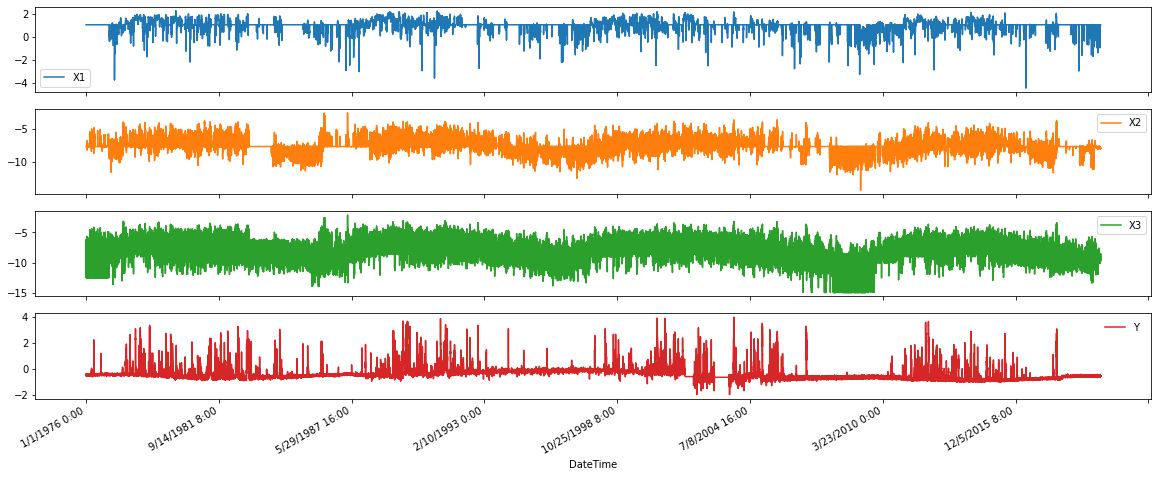

In [5]:
df.plot(figsize=(20,8), subplots=True)
plt.legend(loc='upper right', frameon=False)
plt.show()

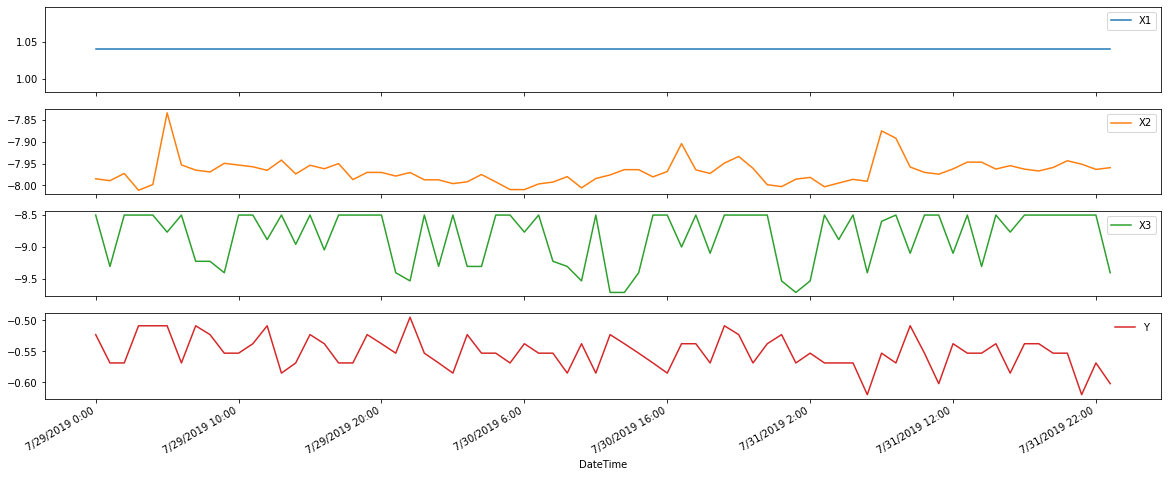

In [6]:
# plot the last 72 hours of the data
df[-72:].plot(figsize=(20,8), subplots=True)
plt.legend(loc='upper right', frameon=False)
plt.show()

In [7]:
df.drop(['X1'], axis=1, inplace=True)

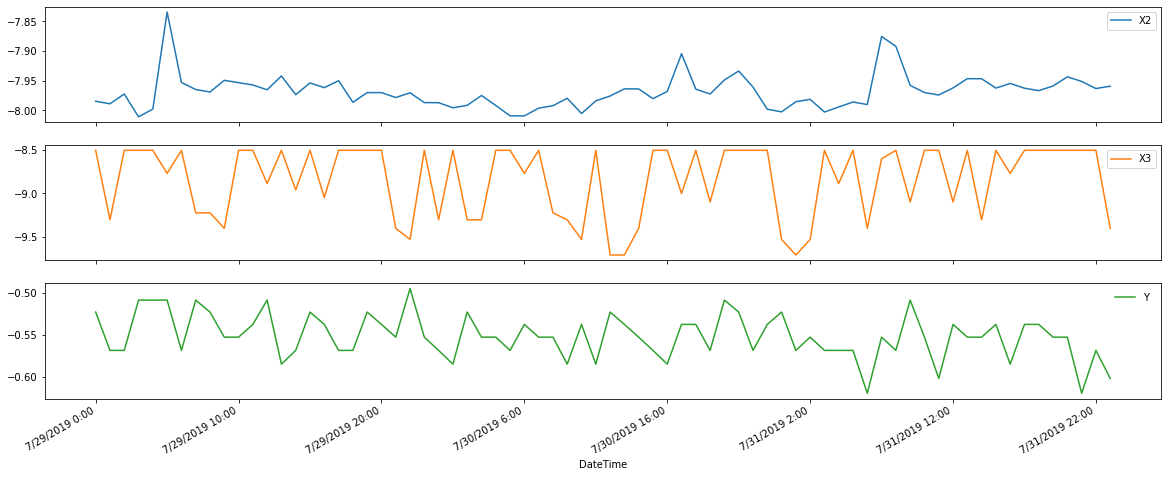

In [8]:
# again, plot the last 72 hours of the data
df[-72:].plot(figsize=(20,8), subplots=True)
plt.legend(loc='upper right', frameon=False)
plt.show()

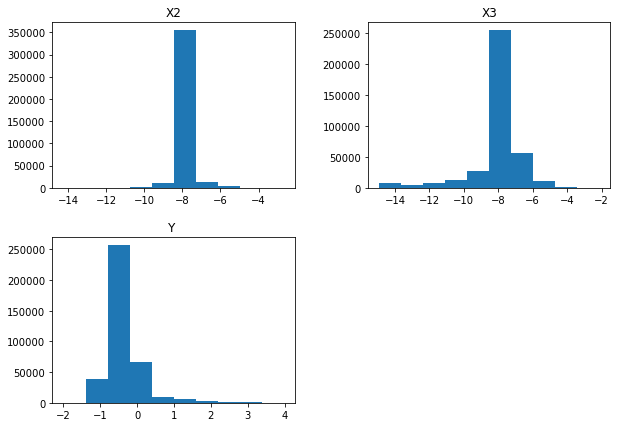

In [9]:
df.hist(figsize=(10,7), grid=False)
plt.show()

In [10]:
df.describe()

,X2,X3,Y
count,382032.000000,382032.000000,382032.000000
mean,-7.696444,-8.351769,-0.407148
std,0.376726,1.461961,0.494149
min,-14.237541,-14.936514,-2.000000
25%,-7.696444,-8.505444,-0.677781
50%,-7.696444,-8.505444,-0.522879
75%,-7.696444,-7.724593,-0.236572
max,-2.661640,-2.123738,3.984527


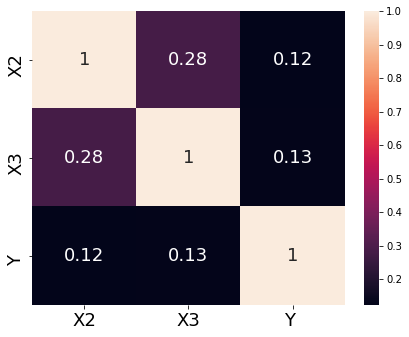

In [11]:
# Inspect the correlation between variables - raw data 
corr = df.corr()
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={'size':18})
heat_map = plt.gcf()
heat_map.set_size_inches(7,6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.figure.subplots_adjust(bottom = 0.2)
plt.show()

In [12]:
# extract features 
values = df.values.astype('float32')

X1 = values[:,0]
X2 = values[:,1]
# X3 = values[:,2]
Y = values[:,2]
# Y = values[:,3]

In [13]:
# MinMax Scaling (Normalization) 
def min_max(data):
	data = data.reshape(-1,1)
	scaler = MinMaxScaler(feature_range=(-1,1))
	return scaler.fit_transform(data)

In [14]:
# normalize features 
n_X1 = min_max(X1)
n_X2 = min_max(X2)
# n_X3 = min_max(X3)
n_Y = min_max(Y)

# Assemble the Normalized Data 
norm_data = np.concatenate([n_X1.reshape(-1,1), 
                            n_X2.reshape(-1,1), 
                            # n_X3.reshape(-1,1), 
                            n_Y.reshape(-1,1)], axis=1)

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
# frame as supervised learning problem 
# Number of observations as output ---> how many hours in the future to be predicted 
num_future_days = 1
num_features = norm_data.shape[1]
look_back = 6 # past window
look_ahead = num_future_days * 24 # future window 
# Framing the forecast problem with an input sequence of 'look_back' past observations to forecast 'look_ahead' future observations 
reframed = series_to_supervised(norm_data, look_back, look_ahead)
print(reframed.shape)

(382003, 90)


In [17]:
# split into train and test sets 
values = reframed.values.astype('float32')
n_train_hours = int(len(values) * 0.7)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print('train:', train.shape, '| test:', test.shape)

train: (267402, 90) | test: (114601, 90)


In [18]:
# split into input and outputs
n_obs = look_back * num_features

train_X, train_y = train[:, :n_obs], train[:, look_ahead+num_features-1]
test_X, test_y = test[:, :n_obs], test[:, look_ahead+num_features-1]

print('train_X:', train_X.shape, '| len(train_X):', len(train_X), '| train_y:', train_y.shape)

train_X: (267402, 18) | len(train_X): 267402 | train_y: (267402,)


In [19]:
# reshape input to be 3D [samples, timesteps, features] 
train_X = train_X.reshape((train_X.shape[0], look_back, num_features))
test_X = test_X.reshape((test_X.shape[0], look_back, num_features))

print('train_X:', train_X.shape, '| train_y:', train_y.shape, '| test_X:', test_X.shape, '| test_y:', test_y.shape)

train_X: (267402, 6, 3) | train_y: (267402,) | test_X: (114601, 6, 3) | test_y: (114601,)


In [20]:
# design the network 
print('Started training ...\n')
batch_size = 1024
model = Sequential()
model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(look_back, num_features)))
model.add(Dropout(0.2))
# To flatten the input to Dense layer 
model.add(Flatten())
# model.add(Dense(1))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
tensorboard_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=0)
print(model.summary())

Started training ...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 5)              180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# fit the model == start the training process 
history = model.fit(train_X, train_y, epochs=100, batch_size=batch_size, validation_split=0.3, callbacks=[tensorboard_callback], verbose=1)
print('Finished training ...')

Train on 187181 samples, validate on 80221 samples
Epoch 1/100
187181/187181 [==============================] - 1s 7us/step - loss: 0.1279 - mape: 106.6689 - val_loss: 0.0265 - val_mape: 79.5422
Epoch 2/100
187181/187181 [==============================] - 1s 5us/step - loss: 0.0213 - mape: 86.7342 - val_loss: 0.0132 - val_mape: 52.4695
Epoch 3/100
187181/187181 [==============================] - 1s 5us/step - loss: 0.0148 - mape: 66.1462 - val_loss: 0.0096 - val_mape: 37.7387
Epoch 4/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0115 - mape: 49.3255 - val_loss: 0.0064 - val_mape: 24.3675
Epoch 5/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0067 - mape: 32.6826 - val_loss: 0.0039 - val_mape: 16.6641
Epoch 6/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0050 - mape: 29.5450 - val_loss: 0.0036 - val_mape: 16.5116
Epoch 7/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0046 - 

187181/187181 [==============================] - 1s 4us/step - loss: 0.0016 - mape: 16.7331 - val_loss: 0.0021 - val_mape: 10.9591
Epoch 58/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0016 - mape: 17.1697 - val_loss: 0.0022 - val_mape: 11.4643
Epoch 59/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0016 - mape: 17.6945 - val_loss: 0.0021 - val_mape: 10.9114
Epoch 60/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0015 - mape: 16.4011 - val_loss: 0.0021 - val_mape: 10.7710
Epoch 61/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0016 - mape: 20.3015 - val_loss: 0.0021 - val_mape: 10.6903
Epoch 62/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0016 - mape: 18.9921 - val_loss: 0.0021 - val_mape: 10.7399
Epoch 63/100
187181/187181 [==============================] - 1s 4us/step - loss: 0.0015 - mape: 16.9019 - val_loss: 0.0021 - val_mape: 10.6354
Epoch

In [22]:
# inverting scaling (Scaled) 
def un_min_max(inv_data, data):
    data = data.reshape(-1,1)
    inv_data = inv_data.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled = scaler.fit_transform(data)
    return scaler.inverse_transform(inv_data)

In [23]:
# make a prediction
print('test_X:', test_X.shape)
pred = model.predict(test_X)
print('pred:', pred.shape)
# De-normalizing the norm. test target 
inv_y = un_min_max(test_y, Y)
# De-normalizing the prediction 
inv_y_hat = un_min_max(pred, Y)

test_X: (114601, 6, 3)
pred: (114601, 1)


In [24]:
# show the model error 
print('RMSE = %.3f' % sqrt(mean_squared_error(inv_y, inv_y_hat[:len(inv_y)])))
print('Min MSE = %.3f' % min(history.history['loss']))
print('Min MSE_val_loss = %.3f' % min(history.history['val_loss']))
print('Min MAPE = %.3f %%' % min(history.history['mape']))

RMSE = 0.083
Min MSE = 0.001
Min MSE_val_loss = 0.002
Min MAPE = 15.131 %


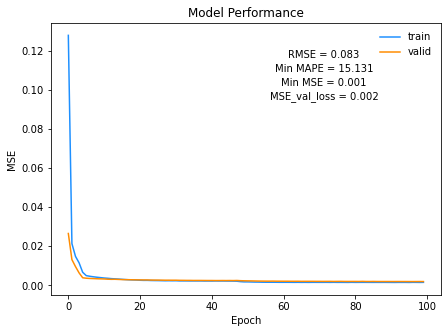

In [25]:
# plot history 
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.plot(history.history['loss'], color='dodgerblue', label='train')
plt.plot(history.history['val_loss'], color='darkorange', label='valid')
plt.legend(loc=0, frameon=False)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Model Performance')
plt.text(0.7, 0.9, 'RMSE = '+'{:.3f}'.format(sqrt(mean_squared_error(inv_y, inv_y_hat[:len(inv_y)]))), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.text(0.7, 0.85, 'Min MAPE = '+'{:.3f}'.format(min(history.history['mape'])), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.text(0.7, 0.8, 'Min MSE = '+'{:.3f}'.format(min(history.history['loss'])), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.text(0.7, 0.75, 'MSE_val_loss = '+'{:.3f}'.format(min(history.history['val_loss'])), horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
plt.show()

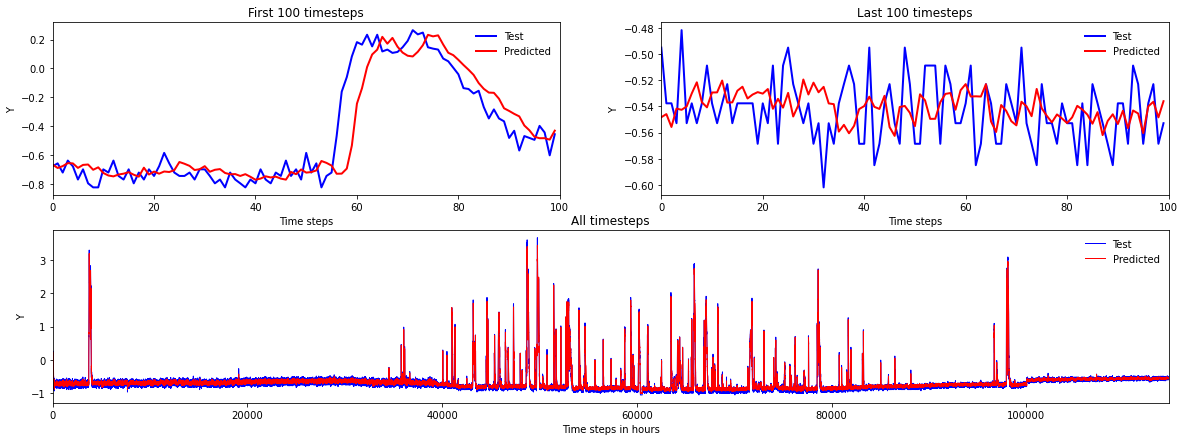

In [26]:
# comparing the true values of the testing data with the prediction 
# Create 2x2 sub plots
gs = gridspec.GridSpec(2,2)

plt.figure(figsize=(20,7))
ax = plt.subplot(gs[0,0]) # row 0, col 0
plt.plot(inv_y[:100], 'blue', linewidth=2, label='Test')
plt.plot(inv_y_hat[:100], 'red', linewidth=2, label='Predicted')
plt.xlim(left=0, right=len(inv_y[-100:]))
plt.legend(loc=0, frameon=False)
plt.xlabel('Time steps')
plt.ylabel('Y')
plt.title('First 100 timesteps')

ax = plt.subplot(gs[0,1]) # row 0, col 1
plt.plot(inv_y[-100:], 'blue', linewidth=2, label='Test')
plt.plot(inv_y_hat[-100:], 'red', linewidth=2, label='Predicted')
plt.xlim(left=0, right=len(inv_y[-100:]))
plt.legend(loc=0, frameon=False)
plt.xlabel('Time steps')
plt.ylabel('Y')
plt.title('Last 100 timesteps')

ax = plt.subplot(gs[1,:]) # row 1, span all columns
plt.plot(inv_y, 'blue', linewidth=1, label='Test')
plt.plot(inv_y_hat, 'red', linewidth=1, label='Predicted')
plt.xlim(left=0, right=len(inv_y))
plt.legend(loc=0, frameon=False)
plt.xlabel('Time steps in hours')
plt.ylabel('Y')
plt.title('All timesteps')
plt.show()

In [27]:
# To forecast future values
def insert_end(Xin, look_back, new_input):
	for i in range(look_back-1):
		Xin[:, i, :] = Xin[:, i+1, :]
	Xin[:, look_back-1, :] = new_input
	return Xin

In [28]:
# forecasting 
first = 0
# just take a subset of 'test_X' to proceed with the forecasting to save time 
sub_Xtest = test_X[-720:, :, :]
sub_Ytest = test_y[-720:]
future = len(sub_Xtest) + look_ahead
norm_forecast = []
Xin = sub_Xtest[first:first+1, :, :]
print(Xin.shape)

for i in range(future):
    out = model.predict(Xin, batch_size=1)
    norm_forecast.append(out[0,0])
    Xin = insert_end(Xin, look_back, out[0,0])
    model.set_weights(model.get_weights())
    model.reset_states()
print('Forecasting is finished ...\n')

norm_forecast = np.asanyarray(norm_forecast)
# Make it 1 column 
norm_forecast = norm_forecast.reshape(-1,1)
# De-Normalize the forecasting 
forecast = un_min_max(norm_forecast, inv_y)

(1, 6, 3)
Forecasting is finished ...



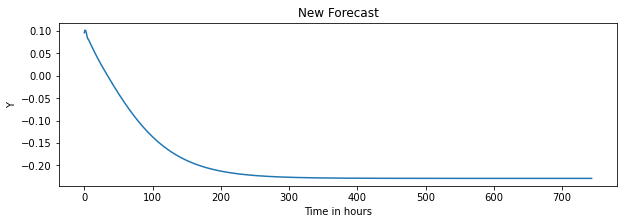

False


In [29]:
fig = plt.subplots(figsize=(10,3))
plt.plot(forecast)
plt.title('New Forecast')
plt.xlabel('Time in hours')
plt.ylabel('Y')
plt.show()
print(DataFrame(forecast).isnull().values.any())

len df_subTest: 48 | len df_forecast: 72
                      subTest  forecast_Y
2019-07-30 00:00:00 -0.508638   -0.228837
2019-07-30 01:00:00 -0.508638   -0.228837
2019-07-30 02:00:00 -0.508638   -0.228837
2019-07-30 03:00:00 -0.568636   -0.228837
2019-07-30 04:00:00 -0.508638   -0.228837
                     subTest  forecast_Y
2019-08-01 19:00:00      NaN   -0.228837
2019-08-01 20:00:00      NaN   -0.228837
2019-08-01 21:00:00      NaN   -0.228837
2019-08-01 22:00:00      NaN   -0.228837
2019-08-01 23:00:00      NaN   -0.228837


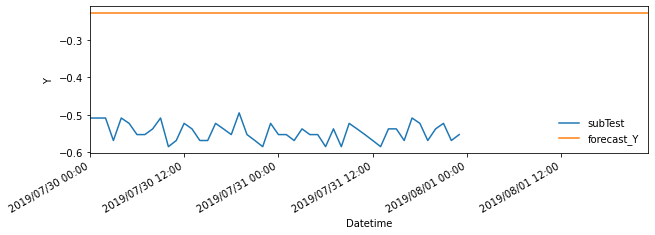

In [30]:
# Take the last '48' points (i.e. hours) of the test set to be plotted with the forecasting 
for_forecast = 48 + look_ahead
time_idx = date_range(to_datetime(df[n_train_hours:][-48:].index)[0], periods=for_forecast, freq='H')

# the number of hours (num of hours of the last subset of the test set + num of hours in future) 
df_subTest = DataFrame(inv_y[-48:], columns=['subTest'])
df_forecast = DataFrame(forecast[-for_forecast:], columns=['forecast_Y'])
print('len df_subTest:', len(df_subTest), '| len df_forecast:', len(df_forecast))
final = concat([df_subTest,df_forecast], ignore_index=True, axis=1)
final = final.rename(columns={0: 'subTest', 1: 'forecast_Y'})
final.index = time_idx
print(final.head())
print(final.tail())

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(final.index, final['subTest'], final['forecast_Y'])
ax.set_xlabel('Datetime')
plt.ylabel('Y')
ax.legend(['subTest', 'forecast_Y'], frameon=False)
ax.set_xlim(left=final.index[0], right=final.index[-1])
myFmt = DateFormatter('%Y/%m/%d %H:%M')
ax.xaxis.set_major_formatter(myFmt)
# Rotate date labels automatically
fig.autofmt_xdate()
plt.show()

In [31]:
print('Execution duration:', datetime.now() - begin_time)

Execution duration: 0:01:22.973099
